# Group Analysis

In [3]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [4]:
process = 'Group_Analysis'
top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
input_path = f'{top_path}/data/interim'
out_path = f'{top_path}/data/interim/{process}'
figure_path = f'{top_path}/reports/figures/{process}'
Path(out_path).mkdir(parents=True, exist_ok=True)
Path(figure_path).mkdir(parents=True, exist_ok=True)

In [5]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
features = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']
annotated_features = ['indoor', 'expanse', 'object_directedness', 
                 'agent_distance', 'facingness', 'joint_action', 
                 'communication', 'valence', 'arousal']

In [6]:
def load_files(files, cat=None, cat_order=None, subj_exclude=['subj001', 'subj002', 'subj003']):
    group = []
    subjs = []
    for file in files:
        subj = file.split('/')[-1].split('_')[0]
        if subj not in subj_exclude: 
            subjs.append(subj)
            df = pd.read_csv(file)
            df['subj'] = subj
            if 'Unnamed: 0' in df.columns:
                df.drop(columns=['Unnamed: 0'], inplace=True)
            group.append(df)
    group = pd.concat(group)
    if cat and cat_order:
        cat_type = pd.CategoricalDtype(categories=cat_order, ordered=True)
        group[cat] = group[cat].astype(cat_type)
    return group, subjs

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

## Pairwise decoding

['subj003', 'subj007', 'subj005', 'subj002', 'subj006']


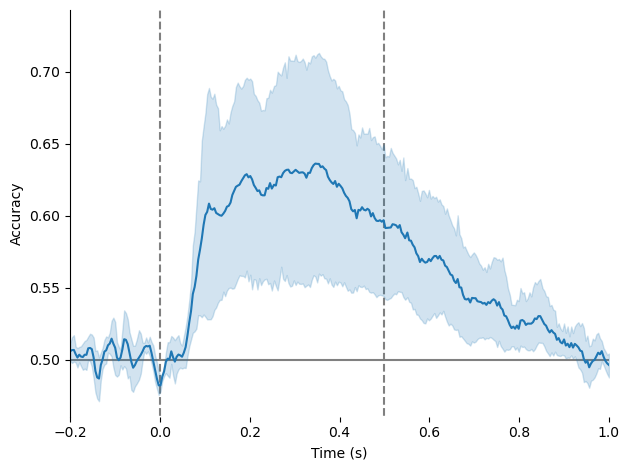

In [15]:
pairwise_decoding, subjs = load_files(glob(f'{input_path}/EEG_RSA/*decoding-distance.csv'))
print(subjs)
decoding_avg = pairwise_decoding.groupby(['time', 'subj']).mean(numeric_only=True).reset_index()
_, ax = plt.subplots()
ymin, ymax = decoding_avg['accuracy'].min(), decoding_avg['accuracy'].max()
sns.lineplot(x='time', y='accuracy', data=decoding_avg, ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time (s)')     
ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
        colors='gray', linestyles='dashed', zorder=0)
ax.hlines(y=0.5, xmin=decoding_avg.time.min(), xmax=decoding_avg.time.max(),
        colors='gray', linestyles='solid', zorder=0)
ax.set_xlim([decoding_avg.time.min(), decoding_avg.time.max()])
ax.set_ylim([ymin, ymax])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{figure_path}/pairwise-decoding.png')

## Feature - EEG RSA

In [7]:
def plot_feature_eeg_rsa(rsa, out_file):
    feature_group = rsa.groupby('feature')
    _, axes = plt.subplots(int(np.ceil(len(features)/3)), 3,
                        figsize=(10,8),
                        sharey=True, constrained_layout=True)
    axes = axes.flatten()
    trim_axs(axes, len(features))
    ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
    for ax, (feature, time_corr) in zip(axes, feature_group):
        sns.lineplot(x='time', y='Spearman rho', data=time_corr, ax=ax)
        if feature in ['alexnet', 'expanse', 'facingness', 'valence']:
            ax.set_ylabel('Spearman rho')
        else:
            ax.set_ylabel('')
            
        if feature in ['communication', 'valence', 'arousal']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
            ax.tick_params(axis='x', which='both', length=0)
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=time_corr.time.min(), xmax=time_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([time_corr.time.min(), time_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(feature)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()


In [8]:
for EEG_metric in ['correlation', 'decoding']:
    rsa, subjs = load_files(glob(f'{input_path}/EEG_RSA/*feature_EEG-{EEG_metric}_rsa.csv'),
                            cat='feature', cat_order=features,
                            subj_exclude=['subj001', 'subj005', 'subj006', 'subj007'])
    print(EEG_metric, subjs)
    out_file = f'{figure_path}/feature_EEG-{EEG_metric}_rsa.png'
    plot_feature_eeg_rsa(rsa, out_file)

correlation ['subj002', 'subj003']


/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_32065/1725940735.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


decoding ['subj002', 'subj003']


/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_32065/1725940735.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


## fMRI - EEG RSA

In [8]:
def plot_fmri_eeg_rsa(rsa, out_file):
    roi_group = rsa.groupby('roi')
    _, axes = plt.subplots(3, 3, sharey=True, sharex=True)
    axes = axes.flatten()
    ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
    for ax, (roi, roi_corr) in zip(axes, roi_group):
        sns.lineplot(x='time', y='Spearman rho', data=roi_corr, ax=ax)
        if roi in ['EVC', 'LOC', 'pSTS']:
            ax.set_ylabel('Spearman rho')
        else:
            ax.set_ylabel('')

        if roi in ['pSTS', 'face-pSTS', 'aSTS']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.tick_params(axis='x', which='both', length=0)

        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=roi_corr.time.min(), xmax=roi_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([roi_corr.time.min(), roi_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(roi)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [9]:
for EEG_metric in ['correlation', 'decoding']:
    for fMRI_metric in ['correlation', 'decoding']:
        rsa, subjs = load_files(glob(f'{input_path}/EEG_RSA/*fMRI-{fMRI_metric}_EEG-{EEG_metric}_rsa.csv'),
                                cat='roi', cat_order=rois)
        print(EEG_metric, subjs)
        rsa = rsa.loc[rsa.subj != 'subj001']
        out_file = f'{figure_path}/fMRI-{fMRI_metric}_EEG-{EEG_metric}_rsa.png'
        plot_fmri_eeg_rsa(rsa, out_file)

correlation ['subj005', 'subj006', 'subj007']
correlation ['subj007', 'subj006', 'subj005']
decoding ['subj006', 'subj007', 'subj005']
decoding ['subj005', 'subj007', 'subj006']


## Feature - EEG Decoding

In [10]:
def plot_decoding(out_file, results, features):
    feature_group = results.groupby('feature')
    _, axes = plt.subplots(int(np.ceil(len(features)/3)), 3,
                        figsize=(10,8),
                        sharey=True, constrained_layout=True)
    axes = axes.flatten()
    trim_axs(axes, len(features))
    ymin, ymax = results['r'].min(), results['r'].max()
    for ax, (feature, time_corr) in zip(axes, feature_group):
        sns.lineplot(x='time', y='r', data=time_corr, ax=ax)
        if feature in ['indoor', 'agent_distance', 'communication']:
            ax.set_ylabel('Prediction (r)')
        else:
            ax.set_ylabel('')
            
        if feature in ['communication', 'valence', 'arousal']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
            ax.tick_params(axis='x', which='both', length=0)
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=time_corr.time.min(), xmax=time_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([time_corr.time.min(), time_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(feature)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [16]:
rsa, subjs = load_files(glob(f'{input_path}/EEG_RSA/*feature_EEG_decoding.csv'),
                        cat='feature', cat_order=annotated_features,
                        subj_exclude=['subj001', 'subj005', 'subj006', 'subj007'])
print(EEG_metric, subjs)
out_file = f'{figure_path}/feature_EEG_decoding.png'
plot_decoding(out_file, rsa, annotated_features)

decoding ['subj002', 'subj003']


/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_26667/2229644866.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


## Feature - fMRI RSA

In [12]:
def feature2color(key=None):
    d = dict()
    d['alexnet'] = np.array([0.5, 0.5, 0.5, 1])
    d['moten'] = np.array([0.5, 0.5, 0.5, 1])
    d['indoor'] = np.array([0.95703125, 0.86328125, 0.25, 0.8])
    d['expanse'] = np.array([0.95703125, 0.86328125, 0.25, 0.8])
    d['object_directedness'] = np.array([0.95703125, 0.86328125, 0.25, 0.8])
    d['agent_distance'] = np.array([0.51953125, 0.34375, 0.953125, 0.8])
    d['facingness'] = np.array([0.51953125, 0.34375, 0.953125, 0.8])
    d['joint_action'] = np.array([0.44921875, 0.8203125, 0.87109375, 0.8])
    d['communication'] = np.array([0.44921875, 0.8203125, 0.87109375, 0.8])
    d['valence'] = np.array([0.8515625, 0.32421875, 0.35546875, 0.8])
    d['arousal'] = np.array([0.8515625, 0.32421875, 0.35546875, 0.8])
    if key is not None:
        return d[key]
    else:
        return d

In [13]:
def plot_feature_fMRI_rsa(rsa, out_file):
    feature_group = rsa.groupby('roi')
    _, axes = plt.subplots(3, 3, figsize=(10,8),
                            sharey=True, sharex=True)
    axes = axes.flatten()
    ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
    for ax, (roi, feature_df) in zip(axes, feature_group):
        sns.barplot(x='feature', y='Spearman rho',
                    data=feature_df, ax=ax, color='gray')
        if roi in ['EVC', 'LOC', 'pSTS']:
            ax.set_ylabel('Spearman rho')
        else:
            ax.set_ylabel('')
            
        if roi in ['pSTS', 'face-pSTS', 'aSTS']:
            ax.set_xticklabels(features, rotation=90, ha='center')
        else:
            ax.tick_params(axis='x', which='both', length=0)

        for bar, feature in zip(ax.patches, features):
            color = feature2color(feature)
            bar.set_color(color)
        
        ax.set_xlabel('')
        ax.set_ylim([ymin, ymax])
        ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
            colors='gray', linestyles='solid', zorder=1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(roi)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [14]:
for stimulus_set in ['train', 'test']:
    for fMRI_metric in ['correlation', 'decoding']:
        rsa, _ = load_files(glob(f'{input_path}/fMRI_RSA/*set-{stimulus_set}_rsa-{fMRI_metric}.csv'),
                            cat='feature', cat_order=features)
        rsa['roi'] = rsa['roi'].astype(pd.CategoricalDtype(categories=rois, ordered=True))
        out_file = f'{figure_path}/fMRI-ROI_set-{stimulus_set}_rsa-{fMRI_metric}.png'
        plot_feature_fMRI_rsa(rsa, out_file)